# **Machine Learning Reconstruction of Surface Ocean pCO₂**
## Ocean-Specific Models
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

We reproduce a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788.  
([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

### Training
Instead of training one global model per member, we now split the data into ocean basins and train a separate XGBoost model for each ocean region for each member. This results in five models per member, which does increase computational cost.

### Reconstruction
Our reconstructions now leverage ocean-awareness in its predictions. All five ocean models are loaded in for each member. Then, we predict for the spatial points in each ocean where SOCAT mask = 0. Predictions are batch-filled into the correct time and lat/lon positions. There is one complete reconstruction generated for each member based off the five ocean models.

### Goal
We hope to improve performance by training separate models per ocean. Each ocean has its own physical, chemical, and biological makeup, and by constraining each ocean to its own model, we hope to better capture these unique elements. The XGBoost model can optimize splits differently for each region without the demands of optimizing for a global fit. Moreover, ocean models focus only on relevant variability, reducing noise and variance. This also helps combat the challenges of data sparsity. Areas with low sampling are not overinfluenced by their abundant counterparts. 

In [1]:
your_username = 'samanthaanwar'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'samanthaanwar'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [2]:
%%capture
!pip install tensorflow
!pip install keras
!pip install plotly

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


E0000 00:00:1745719328.188606      58 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745719328.193135      58 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745719328.205302      58 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745719328.205337      58 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745719328.205339      58 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745719328.205340      58 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

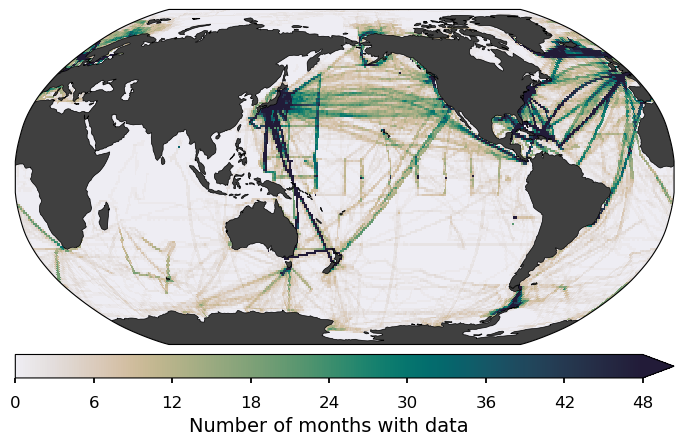

In [5]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
# socat_mask_data = xr.open_mfdataset(socat_path, engine='zarr').sel(time=slice(str(dates[0]),str(dates[-1])))

socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

# 1. Data Introduction and Storage

This remains the same as the original notebook with input features derived from pre-processed Earth System Model (ESM) outputs or inputs. The target variable is **pCO₂-Residual**. The original work used a large ensemble testbed, and we leverage a select number of members from select ensembles in the testbed. We also maintain the data subsampling using a SOCAT mask which ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage

In [6]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

In [7]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"


In [8]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"


# 2.  Earth System Models and their Ensemble Members
This notebook utilizes data from multiple Earth System Models (ESMs) that are part of the **Large Ensemble Testbed (LET)**. The LET originally includes **100 ensemble members** from different ESM, each representing unique initial conditions. These ensemble members are crucial for capturing internal climate variability and assessing model uncertainty.  

However, to optimize computational efficiency and simplify machine learning workflows, we select three representative members from the three ESMs.

In [9]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(MLinputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [10]:
mems_dict

{'ACCESS-ESM1-5': ['member_r10i1p1f1',
  'member_r1i1p1f1',
  'member_r2i1p1f1',
  'member_r31i1p1f1',
  'member_r5i1p1f1'],
 'CanESM5': ['member_r1i1p1f1',
  'member_r1i1p2f1',
  'member_r2i1p1f1',
  'member_r3i1p2f1',
  'member_r6i1p2f1'],
 'MPI-ESM1-2-LR': ['member_r11i1p1f1',
  'member_r12i1p1f1',
  'member_r15i1p1f1',
  'member_r22i1p1f1',
  'member_r23i1p1f1'],
 'UKESM1-0-LL': ['member_r1i1p1f2',
  'member_r2i1p1f2',
  'member_r3i1p1f2',
  'member_r4i1p1f2',
  'member_r8i1p1f2']}

In [11]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']

selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


In [24]:
# derive first_ens and first_mem for reviewers (runthiscell = -1)
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# 3. ML Reconstruction

## 3.1 Data Split

We split data to training data set and testing dataset based on date.

In [15]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

## 3.2 Hyperparameters

In [16]:
params = {
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum depth of each tree to control model complexity
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'subsample': 0.8,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
    'gamma': 0.1,  # Minimum loss reduction required for further partitioning
    'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
    'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
    'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'n_jobs': 30,  # Number of parallel threads to use for training
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
}

# define ocean coords for ocean modeling
ocean_regions = {
    'Pacific':    ((120, -70), (-60, 60)),
    'Atlantic':   ((-70, 20), (-60, 60)),
    'Indian':     ((20, 120), (-60, 30)),
    'Southern':   ((-180, 180), (-90, -60)),
    'Arctic':     ((-180, 180), (60, 90))
}

### Important Note: Run ML (4.3) and Reconstruction (4.4) Part Only Once

The **ML Reconstruction** step needs to be run **only once** for each ML model developed. This helps save computational resources and execution time.

The reconstruction data is saved under our **own username-specific workspace** in GCS. This means that even if you exit and re-enter JupyterHub, your data will remain available, eliminating the need for reprocessing.

### Before Running Again:
Before re-running the ML training steps, make sure a new experiment is actually necessary. Avoiding redundant computations helps optimize time and resource usage. It's also a good idea to monitor your storage regularly and clean up unnecessary files. If you're certain that no new experiment is needed, you can comment out the relevant code (set runthiscell = "0") to prevent accidental re-execution.

For reviewer, set runthiscell to -1.

## 3.3 ML Training

To avoid re-run the ML training, set runthiscell = 0 

In [17]:
def get_ocean_mask(df, lon_col='xlon', lat_col='ylat'):
    masks = {}
    for ocean, ((lon_min, lon_max), (lat_min, lat_max)) in ocean_regions.items():
        if lon_min < lon_max:
            mask = (df[lon_col] >= lon_min) & (df[lon_col] <= lon_max)
        else:
            mask = (df[lon_col] >= lon_min) | (df[lon_col] <= lon_max)
        mask &= (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max)
        masks[ocean] = mask
    return masks

In [20]:
runthiscell = 1

random_seeds = np.load(fs.open(path_seeds))
seed_loc_dict = {ens: {mem: i for i, mem in enumerate(mems)} for ens, mems in mems_dict.items()}

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict
        
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(f"Training models for {ens} {member}")
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee).reset_index()
                df['year'] = df['time'].dt.year
                df['mon'] = df['time'].dt.month
                df['year_month'] = df['time'].dt.strftime('%Y-%-m')
    
                recon_sel = (~df[features_sel + target_sel + ['net_mask']].isna().any(axis=1)) & ((df[target_sel] < 250) & (df[target_sel] > -250)).to_numpy().ravel()
                sel = recon_sel & (df['socat_mask'] == 1)
    
                ocean_masks = get_ocean_mask(df)
                for ocean, ocean_mask in ocean_masks.items():
                    print(f"  Ocean region: {ocean}")
                    ocean_sel = sel & ocean_mask.to_numpy()
    
                    train_sel = ocean_sel & pd.Series(df['year_month']).isin(year_mon).to_numpy()
                    test_sel = ocean_sel & pd.Series(df['year_month']).isin(test_year_mon).to_numpy()
    
                    Xtrain = df.loc[train_sel, features_sel].to_numpy()
                    ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
                    X_test = df.loc[test_sel, features_sel].to_numpy()
                    y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
    
                    N = Xtrain.shape[0]
                    train_val_idx, train_idx, val_idx, test_idx = supporting_functions.train_val_test_split(N, 0.0, 0.2, random_seeds, seed_loc)
                    X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = supporting_functions.apply_splits(Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx)
    
                    model = XGBRegressor(random_state=random_seeds[5, seed_loc], **params)
                    model.fit(X_train_val, y_train_val, eval_set=[(X_val, y_val)], verbose=False)
    
                    # model_name = f"{ens}_{member}_{ocean}"
                    supporting_functions.save_local_ocean_model(model, dates, xgb_model_local_save_dir, ens, member, ocean)
                    y_pred_test = model.predict(X_test)
    
                    test_perf = supporting_functions.evaluate_test(y_test, y_pred_test)
                    test_row = {'model': ens, 'member': member, 'region': ocean, **test_perf}
    
                    file_exists = fs.exists(test_perform_fname)
                    with fs.open(test_perform_fname, 'a') as f:
                        writer = csv.DictWriter(f, fieldnames=test_row.keys())
                        if not file_exists:
                            writer.writeheader()
                        writer.writerow(test_row)
                    print(f"    Test performance ({ocean}):", test_perf)

Training models for ACCESS-ESM1-5 member_r10i1p1f1
  Ocean region: Pacific
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312_Pacific.json
Local model saving process complete.
    Test performance (Pacific): {'mse': 81.0569019273537, 'mae': 5.8988154626117355, 'medae': np.float64(4.025578186384109), 'max_error': np.float64(164.73855506451474), 'bias': np.float64(-0.22269151279874144), 'r2': 0.8910895085615549, 'corr': np.float64(0.9445571852541205), 'cent_rmse': np.float64(9.000406143134372), 'stdev': np.float32(24.892004), 'amp_ratio': np.float64(0.7504994979492062), 'stdev_ref': np.float64(27.280990944750187), 'range_ref': np.float64(412.80027146046496), 'iqr_ref': np.float64(28.13116992474974)}
  Ocean region: Atlantic
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312_Atlantic.

## 3.4 Reconstruction

If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [22]:
runthiscell = 1

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict

    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(f"Reconstructing for {ens} {member}")
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"

            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee).reset_index()
                df['year'] = df['time'].dt.year
                df['mon'] = df['time'].dt.month
                df['year_month'] = df['time'].dt.strftime('%Y-%-m')

                recon_sel = (~df[features_sel + target_sel + ['net_mask']].isna().any(axis=1)) & ((df[target_sel] < 250) & (df[target_sel] > -250)).to_numpy().ravel()
                unseen_sel = recon_sel & (df['socat_mask'] == 0)

                # Initialize empty arrays
                time_sorted = np.sort(df['time'].unique())
                ylat_sorted = np.sort(df['ylat'].unique())
                xlon_sorted = np.sort(df['xlon'].unique())
                full_shape = (len(time_sorted), len(ylat_sorted), len(xlon_sorted))

                recon_unseen_arr = np.full(full_shape, np.nan)
                recon_full_arr = np.full(full_shape, np.nan)
                truth_arr = np.full(full_shape, np.nan)
                socat_arr = np.full(full_shape, np.nan)
                net_arr = np.full(full_shape, np.nan)

                ocean_masks = get_ocean_mask(df)
                # Preload all ocean models once per member
                model_dict = {}
                for ocean, ocean_mask in ocean_masks.items():
                    model_filename = f"model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}_{ocean}.json"
                    model_path = os.path.join(xgb_model_local_save_dir, model_filename)
                    if os.path.exists(model_path):
                        booster = xgb.Booster()
                        booster.load_model(model_path)
                        model = xgb.XGBRegressor()
                        model._Booster = booster
                        model._le = None
                        model_dict[ocean] = model

                # Vectorized predictions per ocean
                for ocean, ocean_mask in ocean_masks.items():
                    ocean_unseen_sel = unseen_sel & ocean_mask.to_numpy()
                    if ocean_unseen_sel.sum() < 50 or ocean not in model_dict:
                        print(f"  Skipping {ocean} (too few unseen samples or model not found)")
                        continue

                    model = model_dict[ocean]

                    X_unseen = df.loc[ocean_unseen_sel, features_sel].to_numpy()
                    y_unseen = df.loc[ocean_unseen_sel, target_sel].to_numpy().ravel()
                    y_pred_unseen = model.predict(X_unseen)

                    df.loc[ocean_unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen

                    # Vectorized batch assignment
                    sub_df = df.loc[ocean_unseen_sel, ['time', 'ylat', 'xlon']].copy()
                    sub_df['pCO2_recon_unseen'] = y_pred_unseen

                    time_index = pd.Series(time_sorted).reset_index().set_index(0)['index']
                    ylat_index = pd.Series(ylat_sorted).reset_index().set_index(0)['index']
                    xlon_index = pd.Series(xlon_sorted).reset_index().set_index(0)['index']

                    t_idx = time_index[sub_df['time']].values
                    y_idx = ylat_index[sub_df['ylat']].values
                    x_idx = xlon_index[sub_df['xlon']].values

                    recon_unseen_arr[t_idx, y_idx, x_idx] = sub_df['pCO2_recon_unseen'].values
                    recon_full_arr[t_idx, y_idx, x_idx] = sub_df['pCO2_recon_unseen'].values
                    truth_arr[t_idx, y_idx, x_idx] = df.loc[ocean_unseen_sel, target_sel[0]].values
                    socat_arr[t_idx, y_idx, x_idx] = df.loc[ocean_unseen_sel, 'socat_mask'].values
                    net_arr[t_idx, y_idx, x_idx] = df.loc[ocean_unseen_sel, 'net_mask'].values

                    unseen_perf = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
                    unseen_row = {'model': ens, 'member': member, 'region': ocean, **unseen_perf}

                    file_exists = fs.exists(unseen_perform_fname)
                    with fs.open(unseen_perform_fname, 'a') as f:
                        writer = csv.DictWriter(f, fieldnames=unseen_row.keys())
                        if not file_exists:
                            writer.writeheader()
                        writer.writerow(unseen_row)
                    print(f"  Unseen performance ({ocean}):", unseen_perf)

                # Create Dataset from full arrays
                DS_recon = xr.Dataset(
                    {
                        'pCO2_recon_unseen': (['time', 'ylat', 'xlon'], recon_unseen_arr),
                        'pCO2_recon_full': (['time', 'ylat', 'xlon'], recon_full_arr),
                        'pCO2_truth': (['time', 'ylat', 'xlon'], truth_arr),
                        'socat_mask': (['time', 'ylat', 'xlon'], socat_arr),
                        'net_mask': (['time', 'ylat', 'xlon'], net_arr)
                    },
                    coords={
                        'time': time_sorted,
                        'ylat': ylat_sorted,
                        'xlon': xlon_sorted
                    }
                )
                supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens, member)

    print('end of all members', datetime.datetime.now())

Reconstructing for ACCESS-ESM1-5 member_r10i1p1f1
  Unseen performance (Pacific): {'mse': 138.0046074697835, 'mae': 7.532227349873175, 'medae': np.float64(5.1059397527002375), 'max_error': np.float64(243.8340753695059), 'bias': np.float64(-0.45395589581547036), 'r2': 0.8534446244930882, 'corr': np.float64(0.9249854456327209), 'cent_rmse': np.float64(11.738761930193268), 'stdev': np.float32(27.034761), 'amp_ratio': np.float64(0.8779776480176966), 'stdev_ref': np.float64(30.686398232495307), 'range_ref': np.float64(499.3369458048631), 'iqr_ref': np.float64(31.600467085008077)}
  Unseen performance (Atlantic): {'mse': 119.06795198899535, 'mae': 7.08208789457443, 'medae': np.float64(4.8174809742376965), 'max_error': np.float64(207.87223328340474), 'bias': np.float64(0.7517438128770646), 'r2': 0.7954448093243565, 'corr': np.float64(0.895542258941747), 'cent_rmse': np.float64(10.885900812730782), 'stdev': np.float32(19.80392), 'amp_ratio': np.float64(0.5769077499694986), 'stdev_ref': np.floa

### 3.4.1 Add pCO2-Temperature back to reconstructed pCO2-Residual, thus recovering pCO2 

## runthiscell = 1  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)


**For the owner who completed the experiment and reconstructed the data:**

1. Ensure that the reconstruction data you saved under the specified path is clean, accurate, and ready for sharing.
2. Only the data you wish to save and provide to reviewers should be kept.
3. Change the permissions to allow others to read the data, ensuring it's accessible to reviewers.


**Reviewers should not run this cell**.


In [27]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


Made public: ACCESS-ESM1-5
Made public: CanESM5
Made public: MPI-ESM1-2-LR


###  3.4.2  Visualize the reconstruction for 1 month

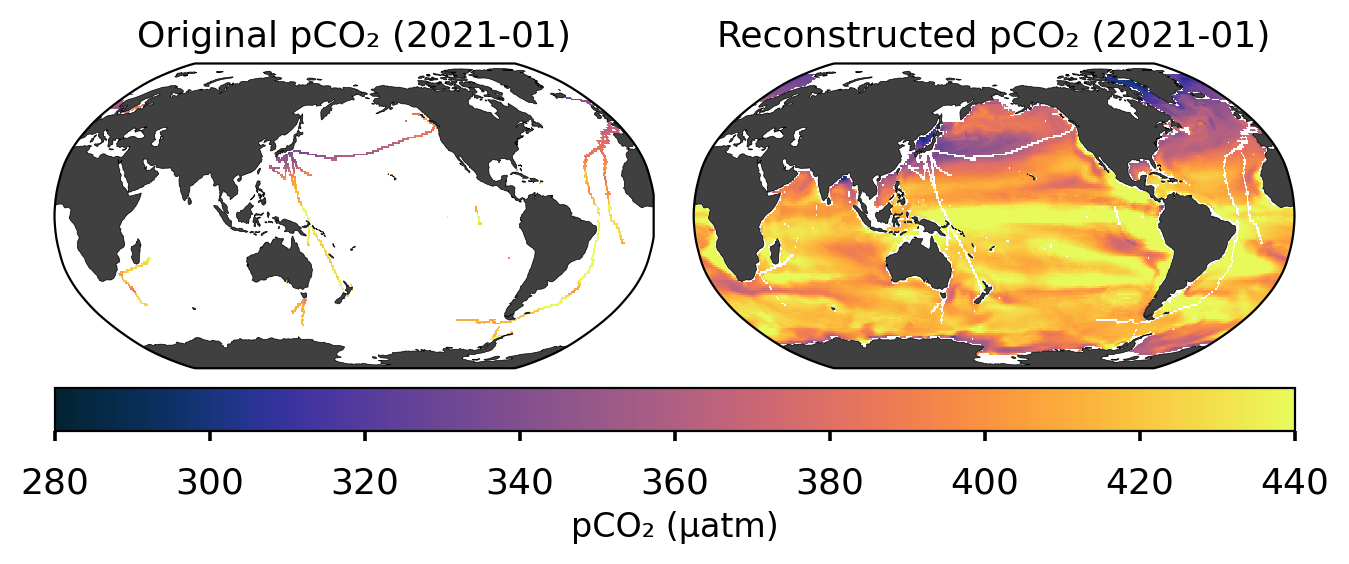

In [26]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title(f"Original pCO₂ ({chosen_time})", ax=0, fontsize=13)
    worldmap.set_title(f"Reconstructed pCO₂ ({chosen_time})", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

# 4. Evaluation of the reconstruction against the original model output

## 4.1 Create a combined dataset with reconstruction and original 

We concatenate the outputs and ground truth from all members and ESMs into a single dataset, and then use this combined dataset to calculate bias, RMSE, and correlation.

In [18]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, time: 240, xlon: 360, ylat: 180, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


## 4.2 Descriptive Statistics

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

You can change the selection for other regions and timeframes and ensemble members.

In [19]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.558233
std          2.783494
min        -50.374261
25%         -1.528943
50%         -0.297992
75%          0.825285
max         19.060741
Name: bias, dtype: float64

## 4.3 Bias Visualizations
Based on this, we could visualize bias between reconstruction and model truth, averaged over the 100 ensemble members, each with a 
monthly resolution over the period init_date through fin_date. Red and blue shading indicates regions where the reconstruction is biased high or low, respectively. 

### 4.3.1 How well does the reconstruction capture the mean pCO2 field? 

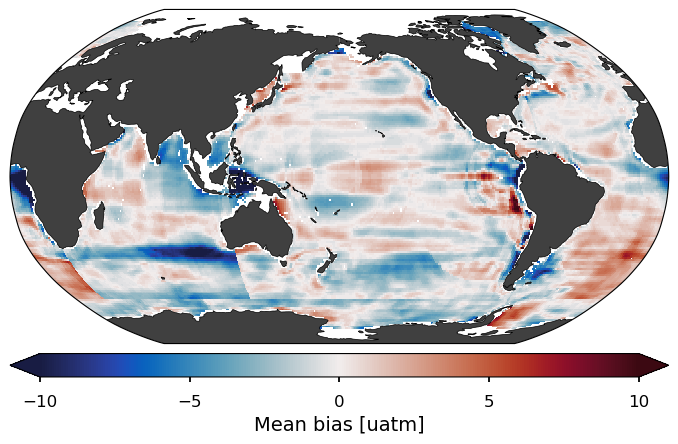

In [20]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


### 4.3.2 Does ESM impact the estimate of the bias? 

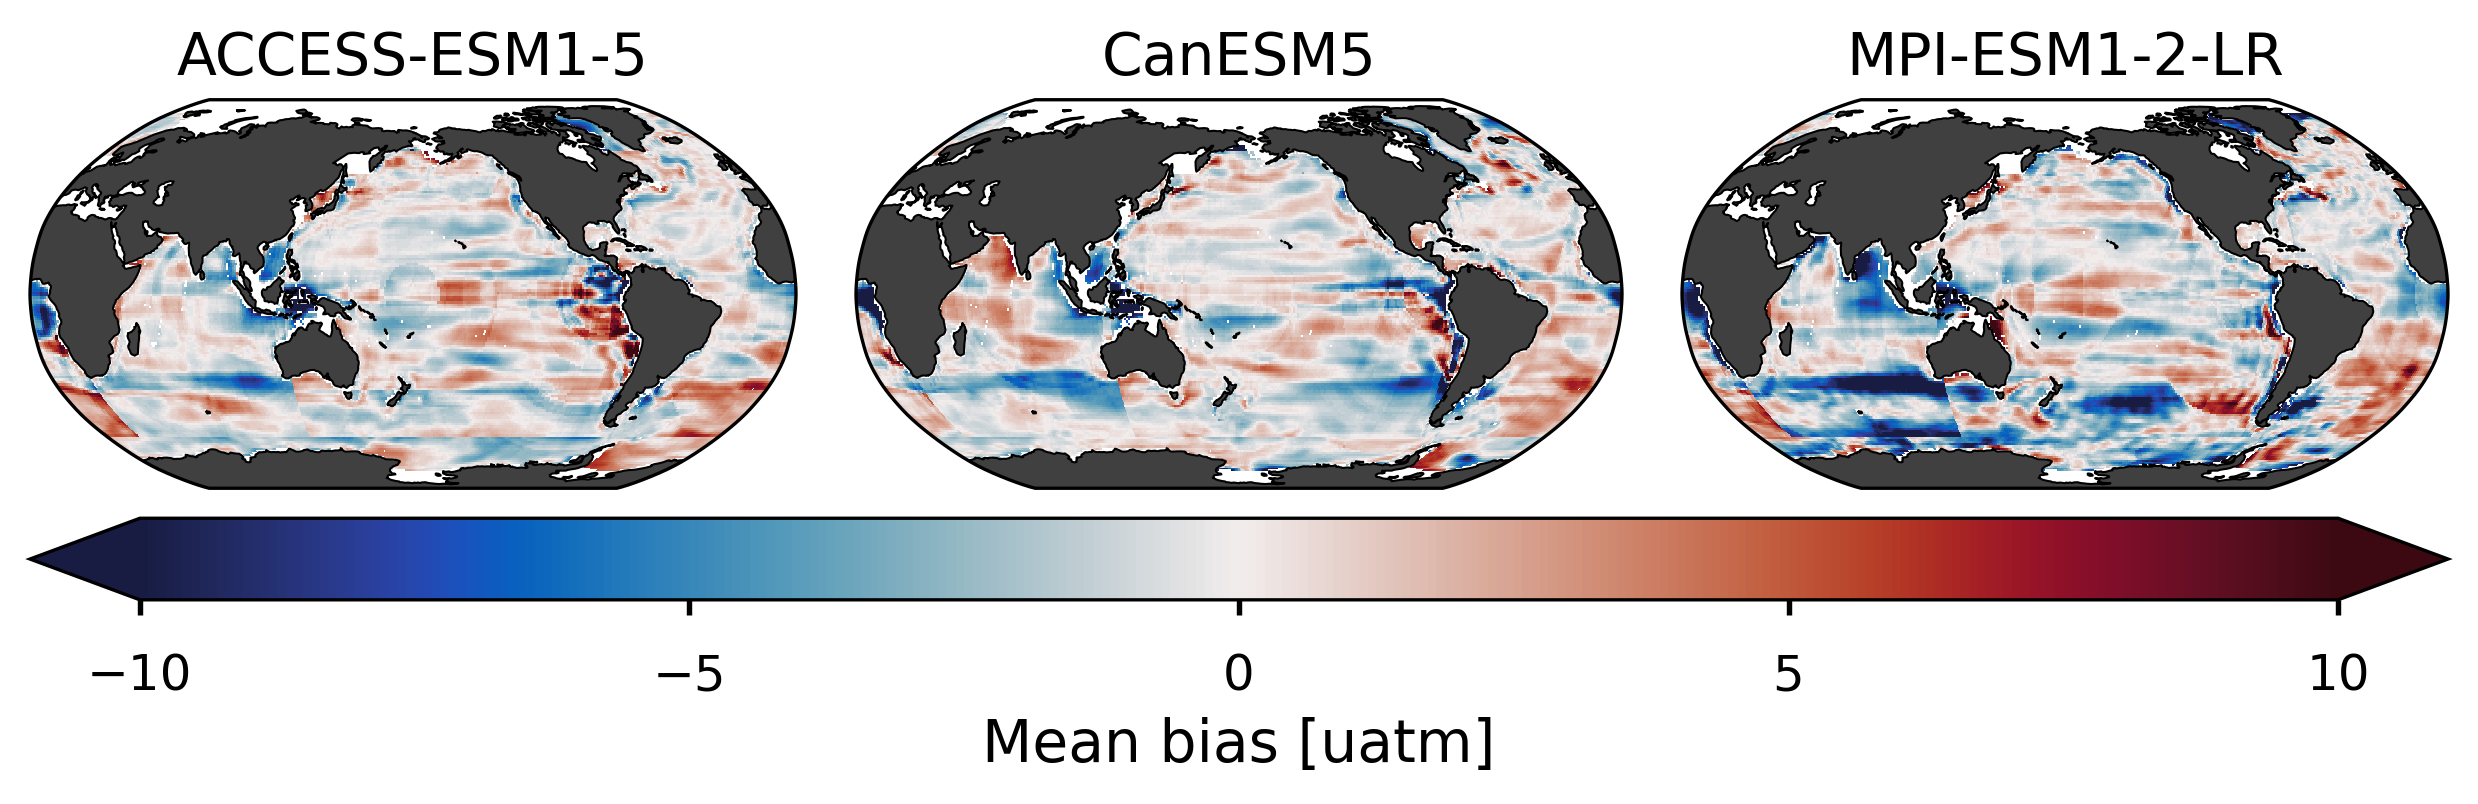

In [21]:
plot_style = "seaborn-v0_8-talk"
ensemble_means = ds_eval['bias'].mean(dim=['member', 'time'])

ensemble_names = list(ds_eval['ens'].values) 

vrange = [-10,10, 5]
cmap = cm.cm.balance

num_ensemble = len(ensemble_names)  
num_cols = 3  
num_rows = (num_ensemble + num_cols - 1) // num_cols 
with plt.style.context(plot_style):
    fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[num_rows, num_cols]) 
    for i in range(num_ensemble):
        data = ensemble_means.isel(ens=i)
        data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)  
        data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                vrange=vrange[0:2], cmap=cmap, ax=i, linewidth_coast=0.5)
        worldmap.set_title(title=ensemble_names[i], ax=i, fontsize=14)

    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)

    worldmap.set_ticks(col, tmin=vrange[0], tmax=vrange[1], dt=vrange[2])

    col.ax.tick_params(labelsize=12)

    plt.show()


##  4.2 Reconstructed variability on seasonal, sub-decadal, and decadal timescales, compared to original model

Before computing spatial correlation metrics, we decompose both the reconstructed and reference pCO₂ fields into their long-term trend, seasonal cycle, and residual components using STL-like decomposition. We then evaluate their agreement by calculating gridwise correlation and standard deviation for each component across all ensemble members and ESMs.


In [22]:
# The calculation of these statistics takes about 1 min/member
ds_eval_corr = eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


Phasing of reconstruction variability on seasonal, sub-decadal, and decadal, compared to original model. Correlation between 
reconstruction and original model on (a) seasonal, (b) sub-decadal, and (c) decadal time scales. 

Here, the average correlations across all ensemble members are shown. 

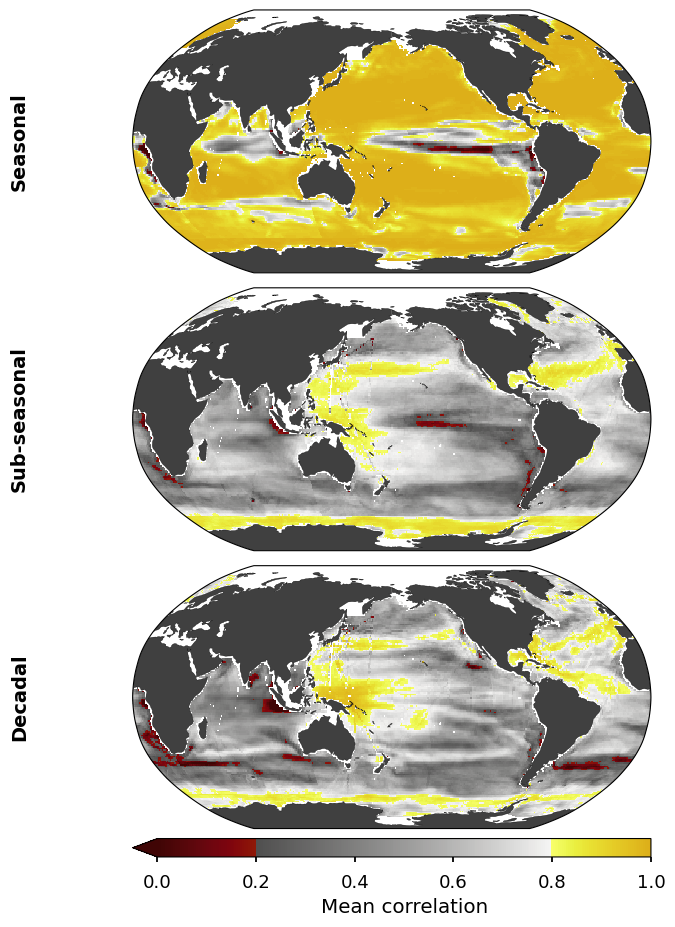

In [23]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world',
                   cbar_mode='edge',
                   axes_pad=0.15,
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[3,1])
    
    # Colorbar ranges
    vrange_col1 = [0, 1, 0.2]
    cmap_col1 = cm.cm.oxy
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Correlation - Annual-variation
    data = ds_eval_corr['corr_seasonal'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)

    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub0 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=0)
    
    
    # Correlation - sub-decadal
    data = ds_eval_corr['corr_residual'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub2 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=1)
    
    # Correlation - decadal
    data = ds_eval_corr['corr_dec'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub4 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=2)
    
    # add colorbar
    col1 = worldmap.add_colorbar(sub0, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col1, f'Mean correlation')
    worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])

    worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    
    plt.show()

The reconstructed pCO₂ has highest fidelity on seasonal timescales, but is less accurate for sub-seasonal and decadal timescale variability. 

### **Final Check for Redundant Files**  

#### **For Both Owners and Reviewers:**  
After execution is complete, review the project directory for any redundant files. Ensure that only necessary and relevant files are retained.  

#### **For Reviewers:**  
Once you have finished reviewing a project, you may delete files related to that project to free up storage space. However, be careful not to remove any data you still need.

As an **owner**, your reconstruction data is stored under:  

```
gs://leap-persistent/{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

If you are **reviewing someone else’s project**, their data and experiment results will be stored under your username in the following path:  

```
gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

After completing the review, you can delete the files under `{owner_username}` in your directory to free up storage space. This ensures that only necessary data is retained while removing redundant files from past reviews.

In [ ]:
if runthiscell == -1:   # Only reviewers should delete data under this path. Everyone should clear redundant data, but be cautious not to delete necessary files.
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    
    blobs = bucket.list_blobs(prefix=prefix)
    
    files_deleted = 0
    for blob in blobs:
        try:
            blob.delete()
            print(f"Deleted: {blob.name}")
            files_deleted += 1
        except Exception as e:
            print(f"Failed to delete: {blob.name}")
            print(e)
    
    if files_deleted > 0:
        print(f"Successfully deleted {files_deleted} files under {reviewing_owner}'s directory.")
    else:
        print(f"No files found for {reviewing_owner}. Nothing was deleted.")


# 5. Additional Information and Further Reading

This Python-based JupyterNotebook and associated utility files have been developed for Project 3 in the course EESC4243/STAT4243/5243 "Climate Prediction Challenges with Machine Learning", Professor Galen McKinley in DEES and Professor Tian Zheng in Statistics, Spring 2025 at Columbia University. The course is also a contribution from the NSF-supported LEAP STC and is intended to run on the LEAP-Pangeo cloud computing and data system. The Github repository for this course is at https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges

Code developed by Course TA Xinyi Ke and Professor Galen McKinley, following from prior work from Dr. Thea Heimdal and Abby Shaum


Additional references in which these methods are employed\
**Heimdal et al. (2024)** *"Assessing improvements in global ocean pCO₂ machine learning reconstructions with Southern Ocean autonomous sampling."* **Biogeosciences** 21: 2159–2176.  
([DOI: 10.5194/bg-21-2159-2024](https://doi.org/10.5194/bg-21-2159-2024))\
**Heimdal, T. H., & McKinley, G. A. (2024)** *"The importance of adding unbiased Argo observations to the ocean carbon observing system."* **Scientific Reports**, 14(1), 19763. ([DOI: 10.1038/s41598-024-70617-x](https://doi.org/10.1038/s41598-024-70617-x) )
